In [1]:
%load_ext nb_black
# !pip install nb_black
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from thundersvm import SVC as svmgpu
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, SMOTENC  # doctest: +NORMALIZE_WHITESPACE

# from multiscorer import MultiScorer
from sklearn.model_selection import cross_val_score
from numpy import average
import xgboost as xgb
from sklearn import metrics as m
import itertools

<IPython.core.display.Javascript object>

In [3]:
randomseed = 7
np.random.seed(randomseed)

<IPython.core.display.Javascript object>

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data=datasets.load_wine()
x=data.data
y=data.target

xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=randomseed,test_size=0.2)


<IPython.core.display.Javascript object>

In [5]:
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>

In [6]:
from sklearn.base import clone


def drop_col_feat_imp(model, X_train, y_train, random_state=42):

    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df

<IPython.core.display.Javascript object>

In [7]:
rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

<IPython.core.display.Javascript object>

In [8]:
from sklearn.base import clone


def imp_df(column_names, importances):
    df = (
        pd.DataFrame({"feature": column_names, "feature_importance": importances})
        #         .sort_values("feature_importance", ascending=False)
        #         .reset_index(drop=True)
    )
    return df


def drop_col_feat_imp(model, X_train, y_train, xtest, ytest, random_state=42):

    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(xtest, ytest)
    benchmark_featureimportance = model_clone.feature_importances_

    print(benchmark_score)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        print(col)
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(xtest.drop(col, axis=1), ytest)
        importances.append(benchmark_score - drop_col_score)
        print(benchmark_score - drop_col_score, drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df, benchmark_score, benchmark_featureimportance

<IPython.core.display.Javascript object>

In [9]:
importances_df, benchmark_score, benchmark_featureimportance = drop_col_feat_imp(
    rf,
    pd.DataFrame(xtrain, columns=data.feature_names),
    ytrain,
    pd.DataFrame(xtest, columns=data.feature_names),
    ytest,
    randomseed,
)

0.9722222222222222
alcohol
0.0 0.9722222222222222
malic_acid
0.0 0.9722222222222222
ash
0.0 0.9722222222222222
alcalinity_of_ash
0.0 0.9722222222222222
magnesium
0.0 0.9722222222222222
total_phenols
0.0 0.9722222222222222
flavanoids
0.0 0.9722222222222222
nonflavanoid_phenols
0.0 0.9722222222222222
proanthocyanins
0.0 0.9722222222222222
color_intensity
-0.02777777777777779 1.0
hue
0.0 0.9722222222222222
od280/od315_of_diluted_wines
0.0 0.9722222222222222
proline
0.0 0.9722222222222222


<IPython.core.display.Javascript object>

In [10]:
Finalvalue = pd.DataFrame()
Finalvalue["features"] = data.feature_names
Finalvalue["benchmark_featureimportance"] = benchmark_featureimportance
Finalvalue["importances_df"] = -importances_df.feature_importance
Finalvalue["newScore"] = benchmark_score - importances_df.feature_importance
Finalvalue = Finalvalue.sort_values(
    by="benchmark_featureimportance", ascending=False
).reset_index(drop=True)

<IPython.core.display.Javascript object>

<BarContainer object of 13 artists>

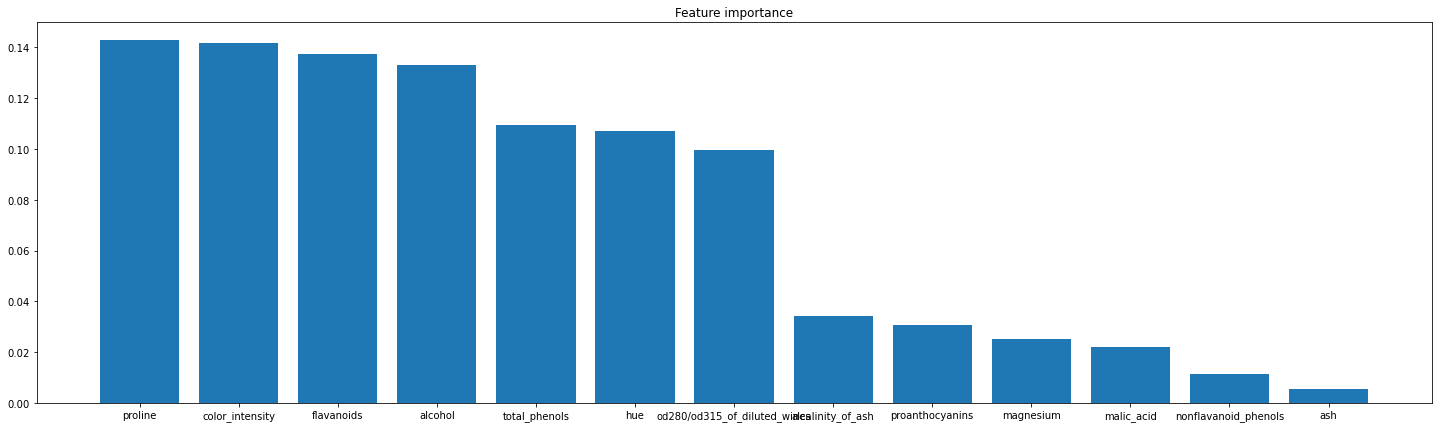

<IPython.core.display.Javascript object>

In [11]:
plt.rcParams["figure.figsize"] = (25, 7)
plt.title("Feature importance")
plt.bar(Finalvalue.features, Finalvalue.benchmark_featureimportance)

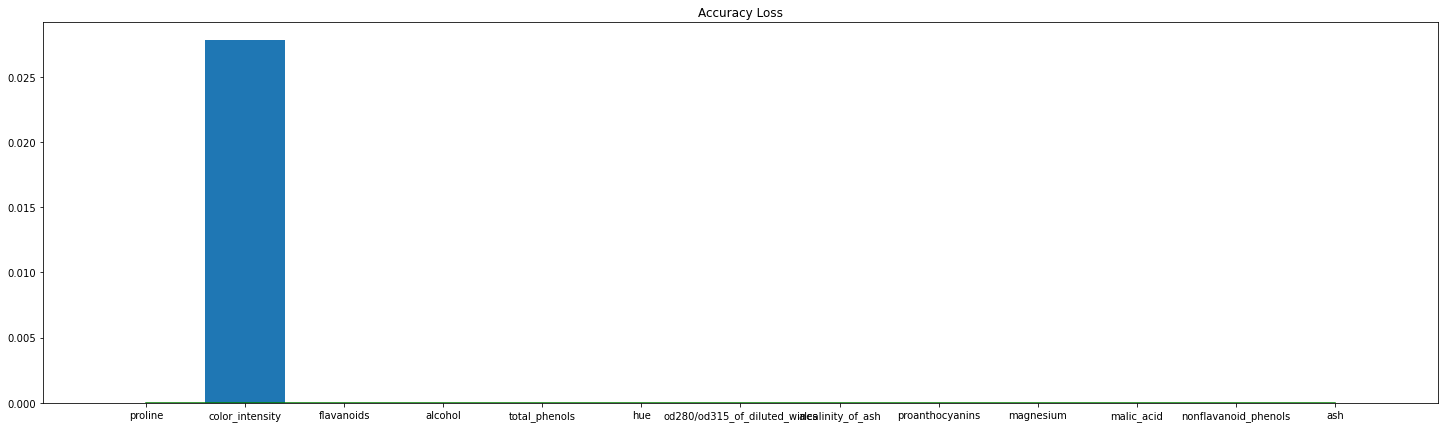

<IPython.core.display.Javascript object>

In [12]:
plt.bar(Finalvalue.features, Finalvalue.importances_df)
plt.title("Accuracy Loss")
plt.plot(
    Finalvalue.features, np.full((len(Finalvalue.features), 1), 0.0), color="green"
)

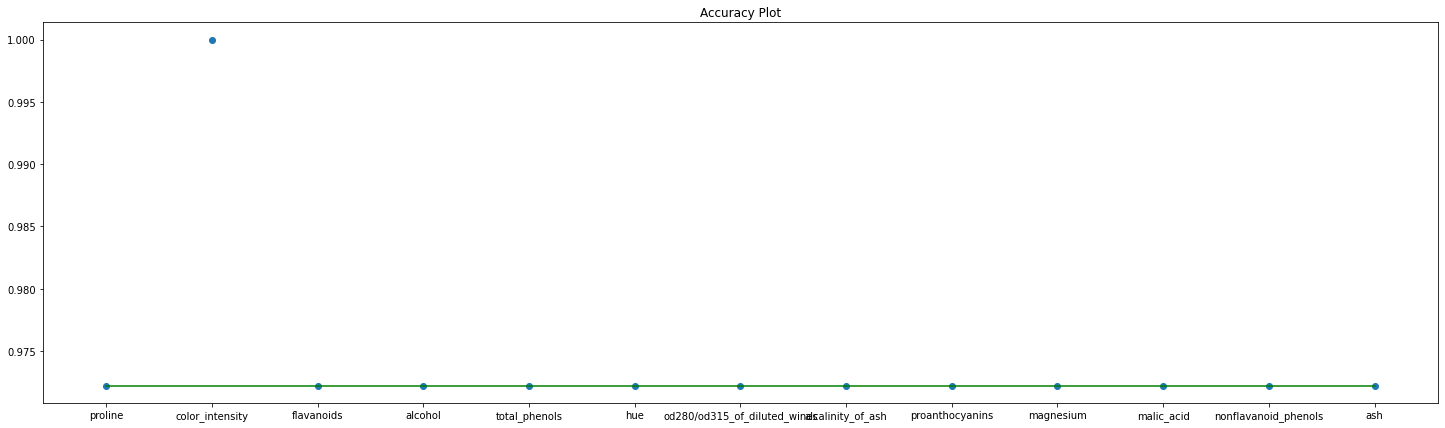

<IPython.core.display.Javascript object>

In [13]:
plt.scatter(Finalvalue.features, Finalvalue.newScore)
plt.title("Accuracy Plot")
plt.plot(
    Finalvalue.features,
    np.full((len(Finalvalue.features), 1), benchmark_score),
    color="green",
)

In [14]:
Finalvalue

,features,benchmark_featureimportance,importances_df,newScore
0,proline,0.142686,-0.000000,0.972222
1,color_intensity,0.141635,0.027778,1.000000
2,flavanoids,0.137545,-0.000000,0.972222
3,alcohol,0.133138,-0.000000,0.972222
4,total_phenols,0.109537,-0.000000,0.972222
5,hue,0.107177,-0.000000,0.972222
6,od280/od315_of_diluted_wines,0.099614,-0.000000,0.972222
7,alcalinity_of_ash,0.034181,-0.000000,0.972222
8,proanthocyanins,0.030859,-0.000000,0.972222
9,magnesium,0.024975,-0.000000,0.972222


<IPython.core.display.Javascript object>